In [1]:
import json, pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
import requests
import time
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import io # 미니맵 처리
from sklearn.preprocessing import MinMaxScaler #스케일 재조정.
match_timeline_list = [] #타임라인 데이터프레임을 모은 리스트
game_id_list = [] #게임ID 모은 리스트
# 우선 데이터를 불러오겠습니다.
with open('Gameinfo_with_user_70000_to_110000_20000toEnd.json', 'r', encoding='utf8') as f:
    dat = json.load(f)

In [2]:
#데이터 형식 확인
dat

[{'gameId': 4732653260,
  'teamId': 100,
  'win': False,
  'participants': [['iSoyelmasfuerte', 'Jhin', 45, 1.92, 45, 1.92, 57, 0],
   ['Known', 'Lulu', 40, 3.47, 41, 3.6, 54, 5],
   ['라면은물붓고3분', 'Jax', 43, 1.23, 43, 2.53, 49, 21],
   ['adventure hunter', 'Kindred', 57, 2.6, 52, 2.1, 54, 556],
   ['알쿵이달쿵', 'Alistar', 68, 3.43, 53, 2.67, 52, 19]]},
 {'gameId': 4728838731,
  'teamId': 200,
  'win': False,
  'participants': [['한계일때 한개 더', 'Yasuo', 60, 2.58, 46, 2.06, 52, 60],
   ['슈슈파나', 'Gnar', 54, 2.76, 54, 2.76, 52, 0],
   ['07050917', 'Aphelios', 43, 2.37, 61, 2.98, 53, 81],
   ['ShanghaiShanghai', 'Thresh', 53, 2.04, 53, 2.04, 60, 0],
   ['병권좌', 'Gragas', 47, 2.38, 58, 3.02, 49, 17]]},
 {'gameId': 4717717877,
  'teamId': 100,
  'win': True,
  'participants': [['흑화 세이버', 'Ornn', 38, 1.44, 38, 1.44, 50, 0],
   ['Str4wberry', 'Leona', 65, 2.69, 61, 3.11, 51, 23],
   ['Known', "Kai'Sa", 41, 2.88, 41, 3.6, 54, 27],
   ['Lilli4', 'Samira', 50, 2.07, 45, 2.08, 54, 2],
   ['명품보카', 'Graves', 

In [5]:
#LOL API KEY


In [22]:
#MAPDATA를 gameID에서 추출함.
for ind in tqdm(range(len(dat))): # 각 게임 아이디마다 요청
    game_id = dat[ind]['gameId']
    game_id_list.append(game_id)
    api_url = f'https://kr.api.riotgames.com/lol/match/v4/timelines/by-match/{game_id}?api_key={api_key}'
    r = requests.get(api_url)
    while r.status_code!=200: # 요청 제한 또는 오류로 인해 정상적으로 받아오지 않는 상태라면, 3초 간 시간을 지연
        time.sleep(3)
        r = requests.get(api_url)
    temp_match = pd.DataFrame(list(r.json().values())[0]) # 전체 데이터 저장 (데이터 값에 딕셔너리 형태로 필요한 정보가 저장)
    temp_timeline = pd.DataFrame()
    len_timeline = temp_match.shape[0]
    for i in range(len_timeline): # 각 게임의 타임라인이 모두 다르기 때문 (1분 가량마다 타임라인이 찍힌다)
        temp_current_timeline = pd.DataFrame(temp_match['participantFrames'].iloc[i]).T
        if i != (len_timeline-1):
            temp_position = pd.DataFrame(list(temp_current_timeline['position'].values), index=temp_current_timeline.index)
            temp_current_timeline = pd.concat([temp_current_timeline, temp_position], axis=1)
            temp_current_timeline.drop('position', axis=1, inplace=True)
        temp_current_timeline['timestamp'] = temp_match['timestamp'][i]
        temp_timeline = pd.concat([temp_timeline, temp_current_timeline], axis=0, sort=False)
    match_timeline_list.append(temp_timeline)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 315/315 [06:14<00:00,  1.19s/it]


In [478]:
for k in range(len(match_timeline_list)): #인덱스 강제정리
    cur_timeline = match_timeline_list[k]
    cur_timeline.sort_values(by=['timestamp', 'participantId'], axis=0, inplace=True)
    cur_timeline.index = list(range(1,11))*(len(cur_timeline)//10)

In [479]:
#match_timeline_list - 확인 
match_timeline_list[0]

,participantId,currentGold,totalGold,level,xp,minionsKilled,jungleMinionsKilled,dominionScore,teamScore,x,y,timestamp
1,1,500,500,1,0,0,0,0,0,221.0,471.0,0
2,2,500,500,1,0,0,0,0,0,311.0,649.0,0
3,3,500,500,1,0,0,0,0,0,560.0,361.0,0
4,4,500,500,1,0,0,0,0,0,560.0,581.0,0
5,5,500,500,1,0,0,0,0,0,351.0,293.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6,6,71,7541,10,6316,17,67,NaN,NaN,NaN,NaN,1320430
7,7,509,6642,12,9283,139,4,NaN,NaN,NaN,NaN,1320430
8,8,465,8715,11,7863,153,8,NaN,NaN,NaN,NaN,1320430
9,9,8,8133,12,9604,149,4,NaN,NaN,NaN,NaN,1320430


In [34]:
#혹시 모르니 저장용...
f = open('MatchTimelineData.pickle', 'wb') # 리스트 안의 데이터프레임 형태이므로 바이너리 코드로 저장하기 위함임
pickle.dump(match_timeline_list, f)
f.close()

In [496]:
#스펠 저장용
spell_api = 'http://ddragon.leagueoflegends.com/cdn/10.22.1/data/ko_KR/summoner.json'
r = requests.get(spell_api)
spell_info_df = pd.DataFrame(r.json())
spells = {}
for i in range(len(spell_info_df)):
    cur_spell = spell_info_df['data'].iloc[i]
    if 'CLASSIC' in cur_spell['modes']:
        spell[int(cur_spell['key'])] = cur_spell['name']
spells = sorted(spell.items(), key=lambda t : t[0])

In [473]:
spell

[(1, '정화'),
 (3, '탈진'),
 (4, '점멸'),
 (6, '유체화'),
 (7, '회복'),
 (11, '강타'),
 (12, '순간이동'),
 (14, '점화'),
 (21, '방어막')]

In [533]:
#맵 좌표 스케일 조정용.

def MapScaler(data, x_range=(-120, 14870), y_range=(-120, 14980)): # x, y의 범위
    x = data['x'].astype('float64').values.reshape(-1, 1)
    y = data['y'].astype('float64').values.reshape(-1, 1)
    x_range = np.array(x_range).astype('float64').reshape(-1, 1)
    y_range = np.array(y_range).astype('float64').reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 512)) # 0~512로 변환
    scaler.fit(x_range)
    x = scaler.transform(x)
    scaler.fit(y_range)
    y = scaler.transform(y)
    return x, 512 - y

# 이미지는 왼쪽 위가 0인데, 지도는 왼쪽 아래가 0이다.
# 그래서 좌표만 뒤집어서 출력을 시키고 싶었는데, 찾기 힘들어서 임의로 y값을 뒤집었다.

In [532]:
match_timeline_list[2][match_timeline_list[2]['participantId']==4]

,participantId,currentGold,totalGold,level,xp,minionsKilled,jungleMinionsKilled,dominionScore,teamScore,x,y,timestamp
4,4,500,500,1,0,0,0,0,0,560.0,581.0,0
4,4,0,500,1,0,0,0,0,0,4334.0,11750.0,60031
4,4,21,521,1,181,0,0,0,0,2561.0,12403.0,120059
4,4,306,806,3,752,9,0,0,0,2868.0,13039.0,180101
4,4,333,1683,4,1395,17,0,0,0,7266.0,7843.0,240131
4,4,640,1990,5,1956,26,0,0,0,1279.0,11802.0,300164
4,4,1035,2385,6,2679,40,0,0,0,2189.0,12447.0,360192
4,4,1493,2843,7,3403,56,0,0,0,2202.0,13534.0,420225
4,4,400,3140,7,3796,63,0,0,0,1068.0,10869.0,480246
4,4,552,3292,7,4005,65,0,0,0,1418.0,8416.0,540246


In [49]:
#위의 매치데이터를 포함하는 게임인포 피클에서 가져옴.
with open('Gameinfo_70000_to_110000.pickle', 'rb') as f:
    match_df = pickle.load(f)

In [50]:
# 우선 인덱스 부여
match_df.index = range(len(match_df))

In [298]:
# 리스트에 있는 애들만 추려낸다. 
match_df0 = pd.DataFrame()
for i in dat:
    for j in match_df.index[20000:]:
        if match_df.loc[j, :]['gameId'] == i['gameId']:  
            match_df0 = pd.concat((match_df0, match_df.loc[j:j,:]))
            
    

In [299]:
# 길이 확인
len(match_df0), len(match_timeline_list)

315

In [81]:
match_df0[match_df0['gameId']==dat[312]['gameId']]

,gameId,gameCreation,gameDuration,queueId,gameVersion,teams,participants,participantIdentities
22826,4742601645,1603708021801,2112,430,10.21.339.2173,"[{'teamId': 100, 'win': 'Win', 'firstBlood': F...","[{'participantId': 1, 'teamId': 100, 'champion...","[{'participantId': 1, 'player': {'platformId':..."


In [541]:
#수정된 방식 - 스마이트 보유자 <2면 단순히 정글미니언 킬수로 판단.

def SupJugPredict1(data, player_spells, i): # 서폿과 정글을 판단하기 위한 함수
    if i==1: # 블루팀
        final_timeline = data.iloc[-10:-5].copy()
        spells = player_spells[:5]
    if i==6: # 레드팀
        final_timeline = data.iloc[-5:].copy()
        spells = player_spells[5:10]
    smite_count = (spells == 11).sum()
    # 각 팀의 스마이트 개수 
    if smite_count <= 1: jungle_index = final_timeline['jungleMinionsKilled'].idxmax()
    elif  smite_count > 1: jungle_index = False
    # else: jungle_index = np.where(spells == 11)[0][0] + i # 강타를 들고있는 플레이어 번호
        
    #final_timeline = final_timeline.drop(index = np.where(spells == 11)[0][0]) #정글 제외
    final_timeline = final_timeline.drop(index=final_timeline['jungleMinionsKilled'].idxmax()) 
    return final_timeline['minionsKilled'].idxmin(), jungle_index # 정글을 제외하고 cs가 가장 적은 사람이 서포터

def LanePredict1(data, support_bool=False, jungle_bool=True):
    lane = {'TOP': 0, 'MID': 0, 'BOT_CARRY': 0, 'JUNGLE':0}
    etc = 0
    for xi, yi in zip(data['x'], data['y']):
        if (xi > 20) & (xi < 60) & (yi > 30) & (yi < 300): lane['TOP'] += 1
        elif (xi > 20) & (xi < 150) & (yi > 20) & (yi < 160) & (1-(xi>90) | 1-(yi>120)): lane['TOP'] += 1
        elif (xi > 30) & (xi < 300) & (yi > 20) & (yi < 60): lane['TOP'] += 1
        elif (xi > 195) & (xi < 265) & (yi > 250) & (yi < 310): lane['MID'] += 1
        elif (xi > 220) & (xi < 295) & (yi > 220) & (yi < 290): lane['MID'] += 1
        elif (xi > 250) & (xi < 320) & (yi > 200) & (yi < 260): lane['MID'] += 1
        elif (xi > 290) & (xi < 350) & (yi > 160) & (yi < 215): lane['MID'] += 1
        elif (xi > 160) & (xi < 220) & (yi > 290) & (yi < 340): lane['MID'] += 1
        elif (xi > 220) & (xi < 460) & (yi > 435) & (yi < 485): lane['BOT_CARRY'] += 1
        elif (xi > 400) & (xi < 490) & (yi > 385) & (yi < 480): lane['BOT_CARRY'] += 1
        elif (xi > 440) & (xi < 490) & (yi > 220) & (yi < 455): lane['BOT_CARRY'] += 1
        elif (xi > 0) & (xi < 170) & (yi > 340) & (yi < 512): etc += 1
        elif (xi > 340) & (xi < 512) & (yi > 0) & (yi < 170): etc += 1
        else: lane['JUNGLE'] += 1
    if jungle_bool:
        #if max(lane, key=lane.get) == 'JUNGLE': return 'JUNGLE', lane #정글이면 확정.
        #elif lane.get('JUNGLE') >4 :  return 'JUNGLE', lane #정글에서 5개 이상 찍히면 확정.
        del lane['JUNGLE']
    # 예측된 서포터 번호가 봇에 가장 오래 있었으면 서포터로 확정, 아니면 라인으로 판단
    if support_bool & any([max(lane, key=lane.get) == 'BOT_CARRY' ]): return 'BOT_SUPPORT', lane
        
    return max(lane, key=lane.get), lane

In [544]:
# 라인 계산 - 순수 포지션 방식으로 재계산

lane_calculated_new = pd.DataFrame()
lane_smite_1_each_new = pd.DataFrame()
lane_from_data_new = pd.DataFrame()
for k in range(len(match_timeline_list)):
#    if k!=45:
        cur_timeline = match_timeline_list[k].copy()
        cur_timeline['jungleMinionsKilled'] = cur_timeline['jungleMinionsKilled'].astype('float64')
        cur_timeline['minionsKilled'] = cur_timeline['minionsKilled'].astype('float64')
        # 타임스탬프는 op.gg가 나타내는 아이템 타임스탬프와 비교 결과, 타임스탬프 값의 1000 단위가 1초인 것을 파악함
        cur_timeline['timestamp'] = cur_timeline['timestamp'] / (1000*60)  # 타임스탬프 값을 분 단위로 변환
        condition = (cur_timeline['timestamp'] > 2) & (cur_timeline['timestamp'] < min(match_df0.iloc[k, :]['gameDuration']/60 -2, 16) )  # 2분 이하 : 미니언이 라인 도착 전, 시야 확보와 정글 리쉬
                        # 16분 이상 또는 게임 끝나기 2분전... : 라인전을 끝내고 다른 라인으로 이동할 수 있음
        cur_timeline = cur_timeline.loc[condition].copy()
        cur_timeline['x'], cur_timeline['y'] = MapScaler(cur_timeline)
        player_spells = [(data['spell1Id'], data['spell2Id']) for data in match_df0.iloc[k, :]['participants'] ] # 스펠 확인
        player_spells = np.array(player_spells)

        lane = {}
        smite_exception = False # 강타 갯수가 각 팀에 하나씩만 있게 확인
        role_temp = [[],[]]

        lane_data = {}
        for i in range(10): #데이터프레임에서 계산...
            info = match_df0['participants'].iloc[k][i]['timeline']['role'], match_df0['participants'].iloc[k][i]['timeline']['lane']
            lane_data[f'lane{i+1}'] = info
        lane_data['gameId'] = match_df0.iloc[k, :]['gameId']


        for i in range(1, 11, 5):  # 라인 계산
            support_index, jungle_index = SupJugPredict1(cur_timeline, player_spells, i)
            smite_exception = smite_exception or (not(jungle_index))
            #smite_index = np.where(spells == 11)[0][0] + i 

            for j in range(i, i+5):
                if j == jungle_index: # 우선 정글 인덱스가 존재해도 정글에서 있는 시점이 없으면.... 
                    lane[f'lane{j}'] = 'JUNGLE'
                    continue
                cur_player = cur_timeline.loc[j].copy()
                role, dic_lane = LanePredict1(cur_player, support_index==j, jungle_index)
                if role == 'BOT_SUPPORT': 
                    lane[f'lane{j}'] = 'BOT_SUPPORT'
                    role_temp[i//5].append('BOT_SUPPORT')
                elif sorted(dic_lane.values())[-1] - sorted(dic_lane.values())[-2] >2: 
                    lane[f'lane{j}'] = role
                    role_temp[i//5].append(role)
                elif sum(dic_lane.values())-dic_lane[role] <=2 : 
                    lane[f'lane{j}'] = role
                    role_temp[i//5].append(role)
                else: 
                    lane[f'lane{j}'] = dic_lane #분명하지 않으면 조건 조작

        for i in range(1,11,5):
            for j in range(i,i+5):
                if str(type(lane[f'lane{j}'])) == "<class 'dict'>":
                    val = lane[f'lane{j}']
                    role = max(val, key=val.get)
                    if role not in role_temp[i//5]:
                        lane[f'lane{j}'] = role
                    else:
                        lane[f'lane{j}'] = 'UNDECIDED'


        lane['gameId'] = match_df0.iloc[k, :]['gameId']
        lane['smiteException'] = smite_exception
        lane['codeIndex'] =k
        lane_data['smiteException'] = smite_exception
        lane_data['codeIndex'] =k
        lane = pd.Series(lane, name = match_df0.index[k])
        lane_data = pd.Series(lane_data, name = match_df0.index[k])
        if any([(lane.value_counts().get('UNDECIDED', 0)> 4), (lane[0:5].value_counts().max()>2) , (lane[5:10].value_counts().max()>2)]): # 각 팀에 한 라인이 3명 이상이면 계산 착오로 판단하여 데이터 삭제
            print(f"{k}번째 계산이 잘못되었습니다.")
            continue
        if len(lane_calculated_new) == 0:
            lane_calculated_new = pd.concat([lane_calculated_new, lane], axis=1, sort=False)
            lane_smite_1_each_new = pd.concat([lane_smite_1_each_new, lane], axis=1, sort=False)
            lane_from_data_new = pd.concat([lane_from_data_new, lane_data], axis=1, sort=False)
        elif lane['gameId'] not in list(lane_calculated_new.loc['gameId', :]):
            if match_df0.iloc[k, :]['gameDuration']<600: # 플레이타임 10분 이상만 추리기
                print(f'오류 : {k}번째 게임은 짧음.')
            else:
                lane_calculated_new = pd.concat([lane_calculated_new, lane], axis=1, sort=False)
                lane_from_data_new = pd.concat([lane_from_data_new, lane_data], axis=1, sort=False)
                if not lane['smiteException']: 
                    lane_smite_1_each_new = pd.concat([lane_smite_1_each_new, lane], axis=1, sort=False)


264번째 계산이 잘못되었습니다.


In [545]:
# 수정된 알고리즘으로 계산
lane_calculated_new

,20020,20022,20037,20061,20069,20076,20084,20089,20090,20097,...,22734,22737,22741,22745,22764,22768,22802,22826,22837,22889
lane1,BOT_CARRY,MID,BOT_CARRY,MID,MID,MID,MID,MID,TOP,BOT_SUPPORT,...,JUNGLE,JUNGLE,TOP,BOT_SUPPORT,BOT_CARRY,BOT_CARRY,TOP,TOP,BOT_CARRY,JUNGLE
lane2,BOT_SUPPORT,TOP,MID,TOP,TOP,BOT_CARRY,JUNGLE,BOT_CARRY,BOT_CARRY,BOT_CARRY,...,TOP,BOT_CARRY,JUNGLE,BOT_CARRY,BOT_SUPPORT,BOT_SUPPORT,BOT_CARRY,BOT_CARRY,JUNGLE,MID
lane3,JUNGLE,JUNGLE,BOT_SUPPORT,BOT_CARRY,BOT_CARRY,JUNGLE,BOT_CARRY,TOP,BOT_SUPPORT,MID,...,BOT_SUPPORT,MID,MID,MID,JUNGLE,TOP,JUNGLE,MID,MID,TOP
lane4,TOP,BOT_SUPPORT,TOP,BOT_SUPPORT,BOT_SUPPORT,BOT_SUPPORT,TOP,BOT_CARRY,MID,JUNGLE,...,MID,TOP,BOT_CARRY,TOP,MID,JUNGLE,BOT_SUPPORT,BOT_SUPPORT,BOT_SUPPORT,BOT_SUPPORT
lane5,MID,BOT_CARRY,JUNGLE,JUNGLE,JUNGLE,TOP,BOT_SUPPORT,JUNGLE,JUNGLE,TOP,...,BOT_CARRY,BOT_SUPPORT,BOT_SUPPORT,JUNGLE,TOP,MID,MID,JUNGLE,TOP,BOT_CARRY
lane6,JUNGLE,BOT_SUPPORT,TOP,JUNGLE,JUNGLE,TOP,BOT_SUPPORT,BOT_CARRY,MID,TOP,...,TOP,TOP,BOT_SUPPORT,MID,TOP,BOT_CARRY,TOP,BOT_CARRY,TOP,TOP
lane7,TOP,TOP,MID,MID,MID,BOT_CARRY,TOP,BOT_SUPPORT,BOT_SUPPORT,MID,...,JUNGLE,BOT_SUPPORT,JUNGLE,JUNGLE,JUNGLE,JUNGLE,MID,JUNGLE,BOT_CARRY,MID
lane8,BOT_CARRY,BOT_CARRY,JUNGLE,BOT_CARRY,BOT_CARRY,MID,MID,TOP,BOT_CARRY,JUNGLE,...,BOT_SUPPORT,JUNGLE,TOP,BOT_CARRY,MID,TOP,JUNGLE,MID,JUNGLE,JUNGLE
lane9,MID,MID,BOT_CARRY,BOT_SUPPORT,BOT_SUPPORT,BOT_SUPPORT,BOT_CARRY,JUNGLE,TOP,BOT_CARRY,...,BOT_CARRY,BOT_CARRY,MID,TOP,BOT_CARRY,MID,BOT_CARRY,TOP,MID,BOT_CARRY
lane10,BOT_SUPPORT,JUNGLE,BOT_SUPPORT,TOP,TOP,JUNGLE,JUNGLE,MID,JUNGLE,BOT_SUPPORT,...,MID,MID,BOT_CARRY,BOT_SUPPORT,BOT_SUPPORT,BOT_SUPPORT,BOT_SUPPORT,BOT_SUPPORT,BOT_SUPPORT,BOT_SUPPORT


In [546]:
# 수정된 알고리즘으로 계산 - 원 피클에서 추출
lane_from_data_new

,20020,20022,20037,20061,20069,20076,20084,20089,20090,20097,...,22734,22737,22741,22745,22764,22768,22802,22826,22837,22889
lane1,"(DUO_CARRY, BOTTOM)","(NONE, JUNGLE)","(DUO, TOP)","(SOLO, TOP)","(NONE, JUNGLE)","(DUO_SUPPORT, BOTTOM)","(NONE, JUNGLE)","(DUO_CARRY, BOTTOM)","(DUO_SUPPORT, NONE)","(DUO_CARRY, BOTTOM)",...,"(DUO_SUPPORT, BOTTOM)","(DUO, MIDDLE)","(SOLO, BOTTOM)","(DUO_SUPPORT, MIDDLE)","(NONE, JUNGLE)","(DUO_SUPPORT, NONE)","(DUO, TOP)","(DUO, TOP)","(SOLO, MIDDLE)","(NONE, JUNGLE)"
lane2,"(SOLO, MIDDLE)","(SOLO, MIDDLE)","(DUO_SUPPORT, BOTTOM)","(DUO_CARRY, BOTTOM)","(SOLO, MIDDLE)","(NONE, JUNGLE)","(SOLO, MIDDLE)","(SOLO, TOP)","(DUO_SUPPORT, NONE)","(SOLO, MIDDLE)",...,"(SOLO, TOP)","(DUO, MIDDLE)","(DUO_SUPPORT, MIDDLE)","(SOLO, BOTTOM)","(DUO_SUPPORT, BOTTOM)","(DUO_SUPPORT, NONE)","(NONE, JUNGLE)","(DUO_CARRY, BOTTOM)","(SOLO, TOP)","(DUO, TOP)"
lane3,"(SOLO, TOP)","(NONE, JUNGLE)","(DUO_CARRY, BOTTOM)","(NONE, JUNGLE)","(SOLO, TOP)","(DUO_CARRY, BOTTOM)","(DUO_CARRY, BOTTOM)","(NONE, JUNGLE)","(DUO_SUPPORT, NONE)","(NONE, JUNGLE)",...,"(SOLO, MIDDLE)","(NONE, JUNGLE)","(SOLO, TOP)","(DUO_CARRY, MIDDLE)","(DUO_CARRY, BOTTOM)","(DUO, NONE)","(DUO_CARRY, BOTTOM)","(NONE, JUNGLE)","(DUO_CARRY, BOTTOM)","(DUO_CARRY, BOTTOM)"
lane4,"(NONE, JUNGLE)","(DUO_SUPPORT, BOTTOM)","(DUO, TOP)","(DUO_SUPPORT, BOTTOM)","(DUO_CARRY, BOTTOM)","(DUO, TOP)","(SOLO, TOP)","(SOLO, MIDDLE)","(DUO_SUPPORT, NONE)","(DUO_SUPPORT, BOTTOM)",...,"(DUO_CARRY, BOTTOM)","(DUO_SUPPORT, BOTTOM)","(DUO_CARRY, MIDDLE)","(NONE, JUNGLE)","(SOLO, TOP)","(DUO_SUPPORT, NONE)","(DUO_SUPPORT, BOTTOM)","(DUO, TOP)","(DUO_SUPPORT, BOTTOM)","(DUO_SUPPORT, BOTTOM)"
lane5,"(DUO_SUPPORT, BOTTOM)","(DUO_CARRY, BOTTOM)","(NONE, JUNGLE)","(SOLO, MIDDLE)","(DUO_SUPPORT, BOTTOM)","(DUO, TOP)","(DUO_SUPPORT, BOTTOM)","(DUO_SUPPORT, BOTTOM)","(DUO_SUPPORT, NONE)","(SOLO, TOP)",...,"(NONE, JUNGLE)","(DUO_CARRY, BOTTOM)","(NONE, JUNGLE)","(SOLO, TOP)","(SOLO, MIDDLE)","(DUO_SUPPORT, NONE)","(DUO, TOP)","(DUO_SUPPORT, BOTTOM)","(NONE, JUNGLE)","(DUO, TOP)"
lane6,"(DUO_CARRY, BOTTOM)","(SOLO, MIDDLE)","(SOLO, TOP)","(DUO_SUPPORT, BOTTOM)","(DUO_CARRY, BOTTOM)","(NONE, JUNGLE)","(NONE, JUNGLE)","(SOLO, MIDDLE)","(DUO_SUPPORT, NONE)","(SOLO, TOP)",...,"(DUO_CARRY, BOTTOM)","(NONE, JUNGLE)","(DUO_CARRY, BOTTOM)","(DUO_SUPPORT, BOTTOM)","(DUO_SUPPORT, BOTTOM)","(DUO_SUPPORT, NONE)","(SOLO, MIDDLE)","(SOLO, MIDDLE)","(SOLO, TOP)","(DUO, TOP)"
lane7,"(DUO_SUPPORT, BOTTOM)","(SOLO, TOP)","(DUO_CARRY, BOTTOM)","(SOLO, MIDDLE)","(SOLO, MIDDLE)","(SOLO, MIDDLE)","(DUO_SUPPORT, BOTTOM)","(DUO_CARRY, BOTTOM)","(DUO_SUPPORT, NONE)","(DUO_SUPPORT, BOTTOM)",...,"(NONE, JUNGLE)","(DUO, TOP)","(NONE, JUNGLE)","(SOLO, TOP)","(NONE, JUNGLE)","(DUO_SUPPORT, NONE)","(NONE, JUNGLE)","(DUO_SUPPORT, BOTTOM)","(SOLO, MIDDLE)","(DUO, TOP)"
lane8,"(SOLO, TOP)","(DUO_CARRY, BOTTOM)","(DUO_SUPPORT, BOTTOM)","(NONE, JUNGLE)","(DUO_SUPPORT, BOTTOM)","(SOLO, TOP)","(SOLO, MIDDLE)","(DUO_SUPPORT, BOTTOM)","(DUO, NONE)","(NONE, JUNGLE)",...,"(SOLO, MIDDLE)","(DUO, TOP)","(SOLO, MIDDLE)","(NONE, JUNGLE)","(SOLO, MIDDLE)","(DUO, NONE)","(DUO_SUPPORT, BOTTOM)","(DUO_CARRY, BOTTOM)","(DUO_CARRY, BOTTOM)","(NONE, JUNGLE)"
lane9,"(SOLO, MIDDLE)","(DUO_SUPPORT, BOTTOM)","(SOLO, MIDDLE)","(DUO_CARRY, BOTTOM)","(SOLO, TOP)","(DUO_CARRY, BOTTOM)","(DUO_CARRY, BOTTOM)","(NONE, JUNGLE)","(DUO_SUPPORT, NONE)","(DUO_CARRY, BOTTOM)",...,"(SOLO, TOP)","(DUO_CARRY, BOTTOM)","(DUO_SUPPORT, BOTTOM)","(DUO_CARRY, BOTTOM)","(DUO_CARRY, BOTTOM)","(DUO_SUPPORT, NONE)","(DUO_CARRY, BOTTOM)","(NONE, JUNGLE)","(NONE, JUNGLE)","(DUO_CARRY, BOTTOM)"
lane10,"(NONE, JUNGLE)","(NONE, JUNGLE)","(NONE, JUNGLE)","(SOLO, TOP)","(NONE, JUNGLE)","(DUO_SUPPORT, BOTTOM)","(SOLO, TOP)","(SOLO, TOP)","(DUO_SUPPORT, NONE)","(SOLO, MIDDLE)",...,"(DUO_SUPPORT, BOTTOM)","(DUO_SUPPORT, BOTTOM)","(SOLO, TOP)","(SOLO, MIDDLE)","(SOLO, TOP)","(DUO_SUPPORT, NONE)","(SOLO, TOP)","(SOLO, TOP)","(DUO_SUPPORT, BOTTOM)","(DUO_SUPPORT, BOTTOM)"


In [547]:
# 중복 포지션 삭제.
jr_drop_new = []
for jr in lane_calculated_new.columns:
    if any([(lane_calculated_new[jr][0:5].value_counts().max()>1) , (lane_calculated_new[jr][5:10].value_counts().max()>1), (lane_calculated_new_0[jr].value_counts().get('UNDECIDED'))]):
        jr_drop_new.append(jr)

In [548]:
len(jr_drop_new)

4

In [560]:
lane_calculated_new.loc[:, jr_drop_new] #예외처리용 출력

,20089,21176,21385,21479
lane1,MID,MID,MID,MID
lane2,BOT_CARRY,JUNGLE,TOP,MID
lane3,TOP,BOT_CARRY,JUNGLE,JUNGLE
lane4,BOT_CARRY,BOT_SUPPORT,UNDECIDED,TOP
lane5,JUNGLE,TOP,BOT_CARRY,BOT_CARRY
lane6,BOT_CARRY,JUNGLE,MID,BOT_SUPPORT
lane7,BOT_SUPPORT,TOP,JUNGLE,MID
lane8,TOP,UNDECIDED,MID,JUNGLE
lane9,JUNGLE,BOT_SUPPORT,UNDECIDED,BOT_CARRY
lane10,MID,TOP,TOP,TOP


In [549]:
lane_calculated_new_0 = lane_calculated_new.drop(columns=jr_drop_new, axis=1)
lane_from_data_new_0 = lane_from_data_new.drop(columns=jr_drop_new, axis=1)

In [550]:
lane_calculated_new_0

,20020,20022,20037,20061,20069,20076,20084,20090,20097,20098,...,22734,22737,22741,22745,22764,22768,22802,22826,22837,22889
lane1,BOT_CARRY,MID,BOT_CARRY,MID,MID,MID,MID,TOP,BOT_SUPPORT,MID,...,JUNGLE,JUNGLE,TOP,BOT_SUPPORT,BOT_CARRY,BOT_CARRY,TOP,TOP,BOT_CARRY,JUNGLE
lane2,BOT_SUPPORT,TOP,MID,TOP,TOP,BOT_CARRY,JUNGLE,BOT_CARRY,BOT_CARRY,BOT_SUPPORT,...,TOP,BOT_CARRY,JUNGLE,BOT_CARRY,BOT_SUPPORT,BOT_SUPPORT,BOT_CARRY,BOT_CARRY,JUNGLE,MID
lane3,JUNGLE,JUNGLE,BOT_SUPPORT,BOT_CARRY,BOT_CARRY,JUNGLE,BOT_CARRY,BOT_SUPPORT,MID,BOT_CARRY,...,BOT_SUPPORT,MID,MID,MID,JUNGLE,TOP,JUNGLE,MID,MID,TOP
lane4,TOP,BOT_SUPPORT,TOP,BOT_SUPPORT,BOT_SUPPORT,BOT_SUPPORT,TOP,MID,JUNGLE,JUNGLE,...,MID,TOP,BOT_CARRY,TOP,MID,JUNGLE,BOT_SUPPORT,BOT_SUPPORT,BOT_SUPPORT,BOT_SUPPORT
lane5,MID,BOT_CARRY,JUNGLE,JUNGLE,JUNGLE,TOP,BOT_SUPPORT,JUNGLE,TOP,TOP,...,BOT_CARRY,BOT_SUPPORT,BOT_SUPPORT,JUNGLE,TOP,MID,MID,JUNGLE,TOP,BOT_CARRY
lane6,JUNGLE,BOT_SUPPORT,TOP,JUNGLE,JUNGLE,TOP,BOT_SUPPORT,MID,TOP,BOT_CARRY,...,TOP,TOP,BOT_SUPPORT,MID,TOP,BOT_CARRY,TOP,BOT_CARRY,TOP,TOP
lane7,TOP,TOP,MID,MID,MID,BOT_CARRY,TOP,BOT_SUPPORT,MID,MID,...,JUNGLE,BOT_SUPPORT,JUNGLE,JUNGLE,JUNGLE,JUNGLE,MID,JUNGLE,BOT_CARRY,MID
lane8,BOT_CARRY,BOT_CARRY,JUNGLE,BOT_CARRY,BOT_CARRY,MID,MID,BOT_CARRY,JUNGLE,TOP,...,BOT_SUPPORT,JUNGLE,TOP,BOT_CARRY,MID,TOP,JUNGLE,MID,JUNGLE,JUNGLE
lane9,MID,MID,BOT_CARRY,BOT_SUPPORT,BOT_SUPPORT,BOT_SUPPORT,BOT_CARRY,TOP,BOT_CARRY,BOT_SUPPORT,...,BOT_CARRY,BOT_CARRY,MID,TOP,BOT_CARRY,MID,BOT_CARRY,TOP,MID,BOT_CARRY
lane10,BOT_SUPPORT,JUNGLE,BOT_SUPPORT,TOP,TOP,JUNGLE,JUNGLE,JUNGLE,BOT_SUPPORT,JUNGLE,...,MID,MID,BOT_CARRY,BOT_SUPPORT,BOT_SUPPORT,BOT_SUPPORT,BOT_SUPPORT,BOT_SUPPORT,BOT_SUPPORT,BOT_SUPPORT


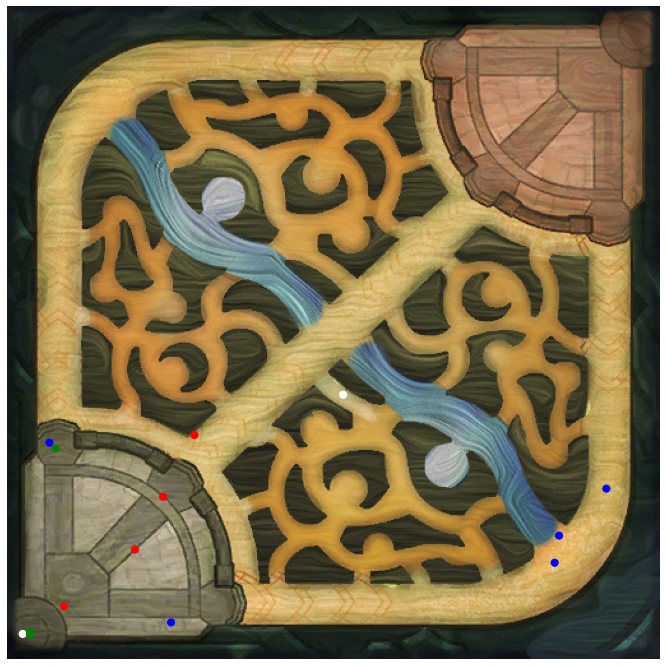

In [562]:
# 각 플레이어의 챔피언의 시간별 포지션 확인하기
#game_id = ""
#k = game_id_list.index(game_id) #게임 아이디 인덱스로 찾기.
k = 7
pos = 4
cur_timeline = match_timeline_list[k].copy()
cur_timeline['x'], cur_timeline['y'] = MapScaler(cur_timeline)
cur_timeline['timestamp'] = cur_timeline['timestamp'] / (1000*60)  # 타임스탬프 값을 분 단위로 변환
cur_player = cur_timeline.loc[pos].copy() #플레이어 데이터 복사.
x = cur_player['x']
y = cur_player['y']
def c_func(num):
    if num<2: return 'w'
    elif num<7: return 'b'
    elif num<12 : return 'g'
    else: return 'r' 
cvec = [c_func(i) for i in cur_player['timestamp']]
max_lane, lane = LanePredict(cur_player, support_index==str(j), jungle_index)

maplink = 'https://s3-us-west-1.amazonaws.com/riot-developer-portal/docs/map11.png'
image = io.imread(maplink)
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.scatter(x, y, c=cvec, s=50)
ax.axis('off')
ax.imshow(image)
plt.show()

In [539]:
list(zip(x,y))

[(14.721280853902602, 485.925298013245),
 (276.8352234823215, 391.1544370860927),
 (414.0744496330887, 408.0741721854305),
 (147.48605737158104, 479.72026490066224),
 (328.2060040026684, 322.89907284768213),
 (470.19292861907934, 397.46119205298015),
 (443.48285523682455, 410.4137748344371),
 (219.6237491661107, 357.8235761589404),
 (311.0254836557705, 434.6235761589404),
 (205.20987324883254, 374.03125827814574),
 (383.5388925950634, 320.2543046357616),
 (180.61747831887922, 195.8484768211921),
 (122.9619746497665, 146.24211920529802),
 (380.2599066044029, 379.1173509933775),
 (457.45270180120076, 388.54357615894037),
 (398.8749833222148, 379.82940397350995),
 (nan, nan)]

In [346]:
xx0, yy0= np.mgrid[0:512:1, 0:512:1]
grid = np.c_[xx0.flatten(), yy0.flatten()]

In [374]:
def func_lane(arr):
    
    if (arr[0] > 20) & (arr[0] < 60) & (arr[1] > 30) & (arr[1] < 300): return 'violet'
    elif (arr[0] > 20) & (arr[0] < 150) & (arr[1] > 20) & (arr[1] < 160) & (1-(arr[0]>90) | 1-(arr[1]>120)): return 'violet'
    elif (arr[0] > 30) & (arr[0] < 300) & (arr[1] > 20) & (arr[1] < 60) : return 'violet'
    elif (arr[0] > 195) & (arr[0] < 265) & (arr[1] > 250) & (arr[1] < 310): return 'red'
    elif (arr[0] > 220) & (arr[0] < 295) & (arr[1] > 220) & (arr[1] < 290): return 'red'
    elif (arr[0] > 250) & (arr[0] < 320) & (arr[1] > 200) & (arr[1] < 260): return 'red'
    elif (arr[0] > 290) & (arr[0] < 350) & (arr[1] > 160) & (arr[1] < 215): return 'red'
    elif (arr[0] > 160) & (arr[0] < 220) & (arr[1] > 290) & (arr[1] < 340): return 'red'
    elif (arr[0] > 200) & (arr[0] < 460) & (arr[1] > 435) & (arr[1] < 485): return 'orange'
    elif (arr[0] > 400) & (arr[0] < 490) & (arr[1] > 385) & (arr[1] < 480): return 'orange'
    elif (arr[0] > 440) & (arr[0] < 490) & (arr[1] > 200) & (arr[1] < 455): return 'orange'
    elif (arr[0] > 0) & (arr[0] < 170) & (arr[1] > 340) & (arr[1] < 512): return 'yellow'
    elif (arr[0] > 340) & (arr[0] < 512) & (arr[1] > 0) & (arr[1] < 170): return 'yellow'
    else: return 'blue'

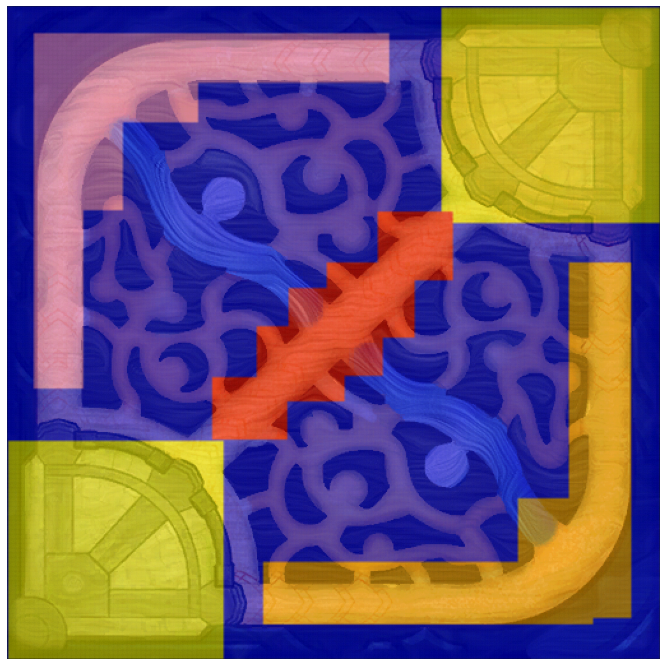

In [540]:
cvec = [func_lane(arr) for arr in grid]
maplink = 'https://s3-us-west-1.amazonaws.com/riot-developer-portal/docs/map11.png'
image = io.imread(maplink)
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.scatter(xx0.flatten(), yy0.flatten(), c=cvec, s=5, alpha=0.1)
ax.axis('off')
ax.imshow(image)
plt.show()

In [487]:
match_timeline_list[4][-10:]

,participantId,currentGold,totalGold,level,xp,minionsKilled,jungleMinionsKilled,dominionScore,teamScore,x,y,timestamp
1,1,1327,21152,18,26924,253,43,NaN,NaN,NaN,NaN,3480891
2,2,-2902,21448,18,26857,254,9,NaN,NaN,NaN,NaN,3480891
3,3,-927,23923,18,24898,288,38,NaN,NaN,NaN,NaN,3480891
4,4,1786,17011,18,20703,23,15,NaN,NaN,NaN,NaN,3480891
5,5,1205,16635,18,22253,27,203,NaN,NaN,NaN,NaN,3480891
6,6,-3560,23720,18,30385,99,191,NaN,NaN,NaN,NaN,3480891
7,7,505,26855,18,36445,391,51,NaN,NaN,NaN,NaN,3480891
8,8,1651,19676,18,27602,181,9,NaN,NaN,NaN,NaN,3480891
9,9,2126,20501,18,27816,93,20,NaN,NaN,NaN,NaN,3480891
10,10,-1505,24323,18,31963,256,59,NaN,NaN,NaN,NaN,3480891


In [564]:
#피클로 데이터 저장
with open('position_conclusion_70000_to_110000_20000toEnd.pickle', 'wb') as f:
    pickle.dump(lane_calculated_new_0, f)
    pickle.dump(lane_calculated_new,f)